# Computer Vision

Roland Kwitt, 2020

## <font color='blue'>Stochastic Gradient Descent (SGD) & Variants</font>

In this lecture, we learn about (mini-batch) **SGD** and extensions such as **momentum** and **Adaptive Moments (ADAM)**. We will start with vanilla gradient descent (GD), i.e., what we have already discussed, then refine it to GD using *partial sums* and eventually take the step towards SGD. Finally, we discuss the above mentioned extensions.

We will use least-squares linear regression in 1D as our running example. This is simple enough to demonstrate and understand the concept.

---

## Content

- [Linear regression (LR) model](#Linear-regression-(LR)-model)
- [Recap of gradient descent](#Recap-of-gradient-descent)
- [Linear regression using vanilla gradient descent](#Linear-regression-using-vanilla-gradient-descent)
- [Linear regression vanilla gradient descent with partial sums](#Linear-regression-using-gradient-descent-with-partial-sums)
- [(Mini-batch) Stochastic gradient descent](#(Mini-Batch)-Stochastic-Gradient-Descent)
- [Limitations and Extensions](#Limitations-and-Extensions)
    - [Momentum](#Momentum)
    - [ADAM](#ADAM)
    
---

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import math
import numpy as np

from mpl_toolkits.mplot3d import axes3d, Axes3D
from matplotlib import cm

---

## Linear regression (LR) model

First, we implement our <font color='blue'>linear regression</font> model as a class which derives from `nn.Module`. This tiny "neural network" simply computes

$$f_{\theta}(\mathbf{x}) = \mathbf{w}^\top\mathbf{x}$$

where $\mathbf{\theta} = [\mathbf{w}]$ parametrizes the function $f$.

In [3]:
class LR(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(1, 1, bias=True) # bias=True means Ax + b, bias=False means Ax
        
    def forward(self, x):
        return self.fc(x)

# use the mean-squared error as loss
loss_fn = nn.MSELoss()

### Some remarks on `torch.nn.Linear`

``torch.nn.Linear`` is derived from `torch.nn.Module`, i.e., the base class for all neural network modules. It implements the following **affine function**:

$$f: \mathbb{R}^n \to \mathbb{R}^m, \quad \mathbf{x} \mapsto \mathbf{W}\mathbf{x}+\mathbf{b}$$

where $\mathbf{x} \in \mathbb{R}^n$, $\mathbf{A} \in \mathbb{R}^{m \times n}$ and $\mathbf{b} \in \mathbb{R}^m$.

The parameters ($\mathbf{W},\mathbf{b}$) are instances of `torch.nn.parameter.Parameter`, i.e., tensors to be considered *module parameters*. This has the advantage that you can easily get *all* parameters of a module by calling `.parameters()`. The total number of parrameters is $n \times m + m$.

**Note**: if we have $m=1$, ``nn.Linear`` implements the map $\langle \mathbf{w},\mathbf{x}\rangle + b$ that we have already seen a couple of times.

In [4]:
# Example
f = nn.Linear(10,5)
print(f.weight)
print(f.weight.size())
print(f.bias)
print(f.bias.size())

n_params = 0
for p in f.parameters():
    n_params += p.numel()
print(n_params)

Parameter containing:
tensor([[-0.1273, -0.1617,  0.1405, -0.0763,  0.2876,  0.2871,  0.0706, -0.1298,
          0.3079,  0.0662],
        [ 0.2073, -0.0756, -0.0515, -0.2416, -0.3075,  0.2945,  0.2229, -0.1718,
          0.2625,  0.1753],
        [-0.1720,  0.2831, -0.2405, -0.1532, -0.1423, -0.3080,  0.0798,  0.2498,
          0.2630,  0.1378],
        [ 0.3050,  0.2943, -0.1168,  0.2795, -0.2113, -0.0628, -0.1889, -0.1600,
         -0.0101,  0.2317],
        [ 0.1567, -0.3081,  0.0545,  0.1017, -0.1117,  0.2004, -0.0664, -0.2418,
         -0.2817, -0.0174]], requires_grad=True)
torch.Size([5, 10])
Parameter containing:
tensor([-0.2824, -0.1573, -0.1744, -0.2140, -0.0320], requires_grad=True)
torch.Size([5])
55


### Toy data

Lets generate some toy data first. Our data samples follow

$$y = 3x +9 + 0.4\epsilon$$

with $\epsilon\sim\mathcal{N}(0,1)$ (i.e., a standard 1D Gaussian). In other words, we have a noisy variant of the linear model $y = 3x + 9$.

w: 3.0
b: 9.0


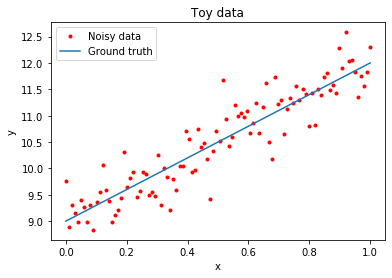

In [5]:
w_true = 3.0
b_true = 9.0

# 100 linearly spaced points in [0,1]
x = torch.linspace(0,1,100).view(-1,1) 

"""
y = 3x + 10 + N(0,1)*0.4
""" 
y = w_true*x + b_true + torch.randn(100,1)*0.4 

plt.plot(x, y, 'r.', label='Noisy data')
plt.plot(x, w_true*x + b_true, label='Ground truth')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Toy data')
plt.legend()

print('w:', w_true)
print('b:', b_true)

## Recap of gradient descent

Say we have a model $f_{\mathbf{\boldsymbol{\theta}}}$ which maps inputs $\mathbf{x} \in \mathcal{X}$ to outputs $y \in \mathcal{Y}$, e.g., a MLP with all parameters aggregated into $\boldsymbol{\theta}$.
Also, assume we have a **loss** function $l: \mathcal{H} \times \mathcal{Z} \to \mathbb{R}_+$, where $\mathcal{Z} = \mathcal{X} \times \mathcal{Y}$ and $\mathcal{H}$ denotes the *hypothesis space*, i.e., the space of all incarnations of our model $f_{\boldsymbol{\theta}}$ depending on $\boldsymbol{\theta}$.

**Example**: In linear regression we have - in general -  $\mathcal{X} \subseteq \mathbb{R}^d$ and $\mathcal{Y} = \mathbb{R}$. Our model (written as a tiny neural network) is a zero hidden layer MLP computing $f_{\mathbf{\boldsymbol{\theta}}}$ 

$$y = f_{\boldsymbol{\theta}}(\mathbf{x}) = \psi(\mathbf{w}^\top\mathbf{x})$$

under some activation functon $\psi: \mathbb{R} \to \mathbb{R}$ (e.g., the identity function). The hypothesis space $\mathcal{H}$ can simply be identified by $\mathbb{R}^d$ here, as the MLP computes a linear mapping followed by some activation function which does not have parameters (at least not in our example).

A suitable loss function would be the mean-squared-error (MSE), i.e.,

$$l^{\text{MSE}}(\boldsymbol{\theta},(\mathbf{x},y)) = (y - f_{\boldsymbol{\theta}}(\mathbf{x}))^2$$

To minimize the loss over our training instances $(\mathbf{x}_1,y_1),\ldots,(\mathbf{x}_N,y_N)$, the gradient descent update rule would look like

$$\boldsymbol{\theta}^{(t+1)} = \boldsymbol{\theta}^{(t)} - \eta \nabla_{\boldsymbol{\theta}} J(\boldsymbol{\theta})$$

with 

$$J(\boldsymbol{\theta}) = \sum_{i=1}^N l^{\text{MSE}}(\boldsymbol{\theta},(\mathbf{x}_i,y_i)) = \sum_{i=1}^N l_i^{\text{MSE}}(\mathbf{\theta})
$$

In other words, we sum up the loss over all training instances and in the gradient descent update rule we need to compute $\nabla_{\boldsymbol{\theta}} J(\boldsymbol{\theta})$, i.e., the gradient of the loss with respect to $\boldsymbol{\theta}$.

**Problem**: Notice that we would have to pass **all** of our data through the model to compute the exact gradient. This can be quite expensive, especially if the input and the model are large (e.g., images).

**Alternatively**, we could run over partial sums. This can be argued by the fact that we estimate a hidden quantity and any partial sum would also be an unbiased estimate, only with higher variance.


## Linear regression using vanilla gradient descent

In [22]:
model = LR()  # model
eta = 1e-1    # learning rate (eta from above)

losses = []
for epoch in range(300):
    
    # zero-out gradients
    model.zero_grad()
    
    # forward pass
    y_hat = model(x)
    
    # compute MSE loss
    loss = loss_fn(y_hat, y)
    
    # backward pass -> compute's gradients
    loss.backward()
    
    # update paramters by hand
    with torch.no_grad():
        for param in model.parameters():
            param.data -= eta * param.grad.data

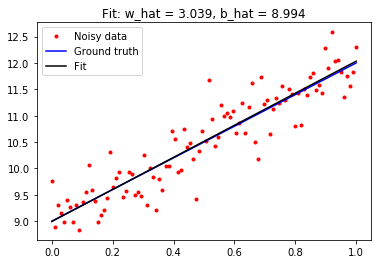

In [23]:
w_hat = model.fc.weight.detach().item()
b_hat = model.fc.bias.detach().item()

plt.plot(x, y, 'r.', label='Noisy data')
plt.plot(x, w_true*x + b_true, 'b', label='Ground truth')
plt.plot(x, w_hat*x + b_hat,'black', label='Fit')

plt.title('Fit: w_hat = {:.3f}, b_hat = {:.3f}'.format(w_hat, b_hat))
plt.legend();

Ok, so that worked :)

## Linear regression using gradient descent with partial sums

Lets implement the *partial sum* idea from above. In particular, we compute partial sums over **batches** of size `B`. This means we first take $(\mathbf{x}_1,y_1),\ldots,(\mathbf{x}_B,y_B)$, then $(\mathbf{x}_{B+1},y_{B+1}),\ldots,(\mathbf{x}_{2B},y_{2B})$ and so on ... After computing the loss over each batch, we compute the gradient with respect to the parameters and update our parameters following the gradient descent update rule.

In [24]:
model = LR() # model
eta = 1e-2   # learning rate 
B = 10       # batch size for partial sums

for epoch in range(200):
    
    # zero-out gradients
    model.zero_grad()
    
    # compute gradient over partial sums
    for b in range(0, x.size(0), B):    
        
        # forward pass -> compute model output on batch
        y_hat = model(x[b:b+B])
        
        # compute MSE loss
        loss = loss_fn(y_hat, y[b:b+B])
        
        # backward pass -> compute gradients
        loss.backward()
    
    # update parameters manually
    with torch.no_grad():
        for param in model.parameters():
            param.data -= eta * param.grad.data

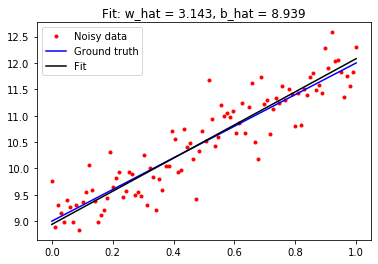

In [25]:
w_hat = model.fc.weight.detach().item()
b_hat = model.fc.bias.detach().item()

plt.plot(x, y, 'r.', label='Noisy data')
plt.plot(x, w_true*x + b_true, 'b', label='Ground truth')
plt.plot(x, w_hat*x + b_hat,'black', label='Fit')

plt.title('Fit: w_hat = {:.3f}, b_hat = {:.3f}'.format(w_hat, b_hat))
plt.legend();

Also worked!

## (Mini-Batch) Stochastic Gradient Descent

When switching to the stochastic variant of gradient descent, i.e., SGD, we update the parameters as follows

$$\boldsymbol{\theta}^{(t+1)} = \boldsymbol{\theta}^{(t)} - \eta \nabla_{\boldsymbol{\theta}} l_{i(t)}(\boldsymbol{\theta}^{(t)})$$

Here the index $l_{i(t)}$ denotes that we randomly choose a **single** sample for gradient computation (typically without replacement) and the update is based on the gradient at this single example. 

This scales extremly well to large datasets. However, it is also not very efficient. Instead, we can compute the gradient over **mini-batches** of samples of size $B$:

$$\boldsymbol{\theta}^{(t+1)} = \boldsymbol{\theta}^{(t)} - \eta \sum_{b=1}^B \nabla_{\boldsymbol{\theta}} l_{i(b)}(\boldsymbol{\theta}^{(t)})$$

This is the most common way to update parameters in training deep neural networks. The original samples are either shuffled initially and then processed sequentially, or a batch of samples is drawn randomly during optimization.

*Intuitively, the stochastic nature helps to escape local minimia during the optimization process*, but the dynamics and the typically observed better generalization of models trained with SGD is still not very well understood in the context of neural networks.

In [26]:
model = LR()             # model
B= 10                    # batch size to use for mini batches
eta = 1e-1               # learning rate

# now, we do not do parameter updates by hand any longer, but rather use 
# PyTorch's implementation of SGD instead.
optim = torch.optim.SGD(
    model.parameters(), 
    lr=eta)

for epoch in range(200):
    
    # create a tensor of indices which we will use to 
    # permute our training data
    perm = torch.randperm(x.size(0))
        
    # iterate over batches of size B
    for b in range(0, x.size(0), B):
        
        # zero-out gradients
        optim.zero_grad()
        
        # forward pass for a batch of samples
        y_hat = model(x[perm][b:b+B])
        
        # compute MSE loss for that batch
        loss = loss_fn(y_hat, y[perm][b:b+B])
        
        # backward pass -> compute gradients
        loss.backward()
        
        # take an optimizer step (i.e., do the parameter update)
        optim.step()

Notice the difference in when we call `optim.step` (within the loop of iterating over the batches). Previously, we accumulated the gradients (over the partial sums, or over the whole dataset).

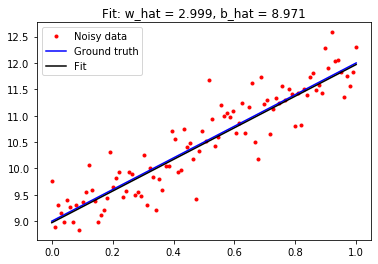

In [27]:
w_hat = model.fc.weight.detach().item()
b_hat = model.fc.bias.detach().item()

plt.plot(x, y, 'r.', label='Noisy data')
plt.plot(x, w_true*x + b_true, 'b', label='Ground truth')
plt.plot(x, w_hat*x + b_hat,'black', label='Fit')

plt.title('Fit: w_hat = {:.3f}, b_hat = {:.3f}'.format(w_hat, b_hat))
plt.legend();

### Comparison to linear regression in `sklearn`

In [28]:
import numpy as np
from sklearn.linear_model import LinearRegression

x_np = x.numpy()
y_np = y.numpy()

reg = LinearRegression().fit(x_np, y_np)
print('w_hat:', reg.coef_[0,0])
print('b_hat:', reg.intercept_[0])

w_hat: 3.0193138
b_hat: 9.004908


## Limitations and Extensions

The main problem we have so far is that the **step size / learning rate** ($\eta$) is fixed, i.e., all parameters are updated in the same manner. This makes a strong assumption about the *local curvature* and about its isotropy - It can easily happen that the same step size does not make sense for all the parameters (or parameter dimensions).

**Example**

In [13]:
f0 = lambda x,y: 1.0*x**2 + 1.0*y**2 # Test case 1
f1 = lambda x,y: 1.0*x**2 + 0.1*y**2 # Test case 2

X = np.linspace(-2.5, 2.6, 51)
Y = np.linspace(-2.5, 2.6, 51)
X, Y = np.meshgrid(X, Y)
Z0 = f0(X,Y)
Z1 = f1(X,Y)

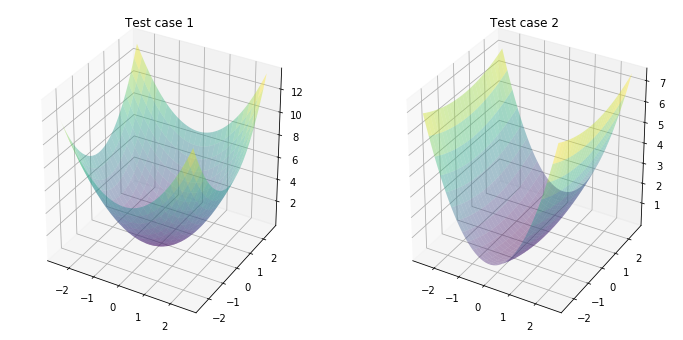

In [14]:
fig = plt.figure(figsize=(12,6))
def plt_fun(fig, X, Y, Z, where, title):
    ax = fig.add_subplot(where, projection='3d')
    ax.plot_surface(X, Y, Z, cmap=cm.viridis, antialiased=True, alpha=0.4);
    plt.title(title)

plt_fun(fig, X, Y, Z0, '121', 'Test case 1')
plt_fun(fig, X, Y, Z1, '122', 'Test case 2')

To illustrate the issue of the same step size for each paramter, we first write a simple function to find the minimum.

In [15]:
def find_min(start, steps, f, lr=0.1, momentum=None):
    
    """
    Starting point for minimum finding is [a,b]. We set requires_grad=True as 
    we need gradients computed for the initial point, as we want to move towards
    the minimum during optimization.
    """
    at = torch.tensor(start, requires_grad=True)
    
    # we can use whatever we want here, so lets just use SGD
    if momentum is None:
        optim = torch.optim.SGD([at], lr=lr)
    else:
        optim = torch.optim.SGD([at], lr=lr, momentum=momentum)
    
    # keep track of the starting point during optimization
    pts = np.zeros((steps, 2))
    
    # run a couple of update steps
    for i in np.arange(200):
        
        # reset all gradients to zero
        optim.zero_grad()
        
        # our loss is simply the function evaluated at the current point
        loss = f(at[0], at[1])
        
        # compute gradient
        loss.backward()
        
        # store intermediate results
        pts[i,0] = at[0].detach().item()
        pts[i,1] = at[1].detach().item()
        optim.step()
        
    return pts

### Learing rate analysis

In [16]:
def cplot(eta, f, contour, title_str, momentum=None):
    plt.figure()
    pts = find_min(start=[-2., -1.], 
                   steps=200, 
                   f=f, 
                   lr=eta, 
                   momentum=momentum)
    plt.contour(X,Y,contour,40)
    plt.plot(pts[:,0],pts[:,1],'-', markersize=4, color='red',marker='o');
    plt.title('learning rate = {:.3f} ({}) [{:.2f}, {:.2f}]'.format(
        eta, 
        title_str,
        pts[-1,0], pts[-1,1]))

Lets test different learning rates and visualize the starting point trajectories ...

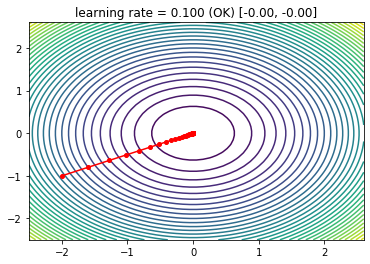

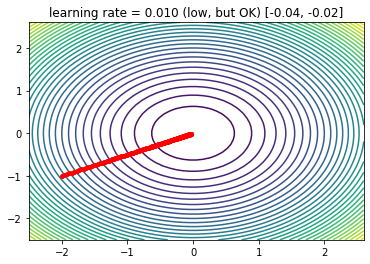

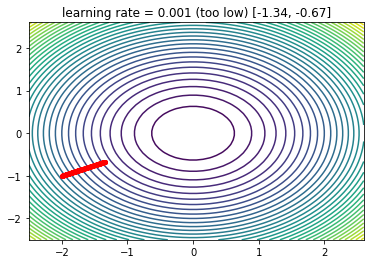

In [17]:
f0 = lambda x,y: torch.pow(x,2.) + torch.pow(y, 2.) # same as f0 before, just with torch
cplot(1e-1, f0, Z0, 'OK')
cplot(1e-2, f0, Z0, 'low, but OK')
cplot(1e-3, f0, Z0, 'too low')

### Isotropy analysis

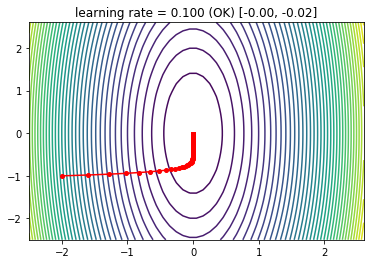

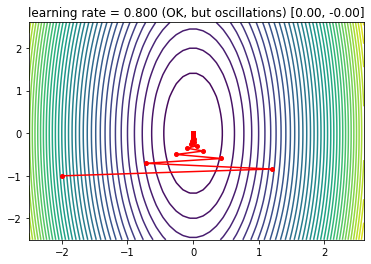

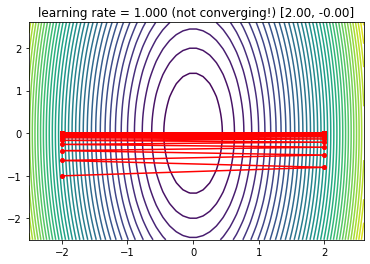

In [18]:
f1 = lambda x,y: torch.pow(x,2.) + 0.1*torch.pow(y, 2.)

cplot(0.1, f1, Z1, 'OK')
cplot(0.8, f1, Z1, 'OK, but oscillations')
cplot(1.0, f1, Z1, 'not converging!')

While **higher order** optimization methods (e.g., methods that take the local curvature into account) would use a more accurate local model of the function to optimize, these methods typically do not scale well with problem size.

### Momentum

In **deep learning**, we rely on methods which make a *smart* use of the gradient, in particular, statistics over its past values. This leads to the notion of **momentum**. In particular, using momentum, we first compute

$$\mathbf{u}^{(t)} = \gamma \mathbf{u}^{(t-1)} + \eta \mathbf{g}^{(t)}$$

where $ \mathbf{g}^{(t)}$ denotes the current gradient and $\gamma>0$ controls the momentum. Parameters are then updated according to

$$\boldsymbol{\theta}^{(t+1)} = \boldsymbol{\theta}^{(t)} - \mathbf{u}^{(t)}$$

We see that this accelerates the update process if the gradient does not change much, but also dampens oscillations in narrow valleys. This is easy to see upon letting $\mathbf{u}^{(t)} = \mathbf{u}^{(t-1)} = \mathbf{u}$. In that case

$$ \mathbf{u} = \frac{\eta}{1-\gamma}\mathbf{g}$$


Lets re-run the previous example where we observed divergence.

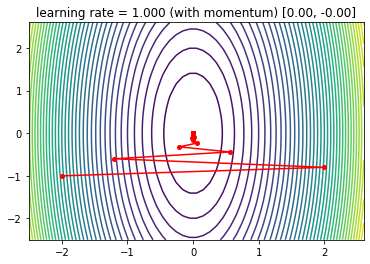

In [19]:
cplot(1.0, f1, Z1, 'with momentum', 0.2)

### ADAM

Kingma & Ba (2019) introduced **ADAM (Adaptive Moments)** to overcome potential non-isotropy issues. In particular, ADAM computes moving averages of each parameter coordinate and its square for rescaling. In fact, it can be seen as a combination of momentum and a per-coordinate scaling. Internally, ADAM operates as follows:

$$
\begin{eqnarray}
\mathbf{m}^{(t)} & = \beta_1 \mathbf{m}^{(t-1)} + (1-\beta_1)\mathbf{g}^{(t)} \\
\hat{\mathbf{m}}^{(t)} & = \frac{\mathbf{m}^{(t)}}{1-\beta^t_1} \\
\mathbf{v}^{(t)} & = \beta_2 \mathbf{v}^{(t-1)}  + (1-\beta_2)\big(\mathbf{g}^{(t)}\big)^2 \\
\hat{\mathbf{v}}^{(t)} & = \frac{\mathbf{v}^{(t)}}{1-\beta^t_2} \\
\mathbf{w}^{(t+1)} & = \mathbf{w}^{(t)} - \frac{\eta}{\sqrt{\hat{\mathbf{v}}^{(t)}}} \hat{\mathbf{m}}^{(t)}
\end{eqnarray}
$$



In [20]:
def find_min_ADAM(start, steps, f, lr=0.1):
    at = torch.tensor(start, requires_grad=True)
    optim = torch.optim.Adam([at], 
                            lr=lr,
                            betas=(0.9, 0.999))
        
    pts = np.zeros((steps, 2))
    for i in np.arange(200):
        optim.zero_grad()
        loss = f(at[0], at[1])
        loss.backward()
        pts[i,0] = at[0].detach().item()
        pts[i,1] = at[1].detach().item()
        optim.step()
        
    return pts

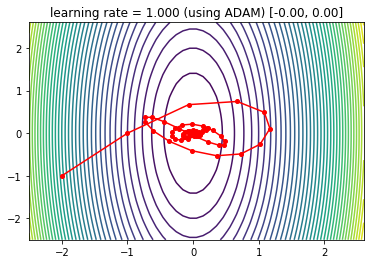

In [21]:
eta = 1.0
plt.figure()
pts = find_min_ADAM(start=[-2., -1.], 
               steps=200, 
               f=lambda x,y: torch.pow(x,2.) + 0.1*torch.pow(y, 2.), 
               lr=eta)
plt.contour(X,Y,Z1,40)
plt.plot(pts[:,0],pts[:,1],'-', markersize=4, color='red',marker='o');
plt.title('learning rate = {:.3f} (using ADAM) [{:.2f}, {:.2f}]'.format(eta, 
                                                                       pts[-1,0], pts[-1,1]));

ADAM and SGD with momentum are a good default choice for optimization, as optimization will also be less sensitive to the choice of learning rate (see previous example). However, there are many other choices as well and new methods are developed rapidly.